In [1]:
import os
from tqdm.notebook import tqdm
from random import shuffle
import datetime

import matplotlib.pyplot as plt
import numpy as np

import torch
import gsplat
from PIL import Image
from torch import optim
import torchvision.transforms as transforms

from src.model.gaussians import Gaussians
from src.data.colmap import ColmapDataSet

In [2]:
ROOT_DIR = '/media/jip/T7/thesis/code/data/'
if not os.path.isdir(ROOT_DIR):
    ROOT_DIR = '/home/jip/data1/'
ROOT_DIR += "bicycle"

DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
try:
    torch.cuda.set_device(DEVICE)
except:
    print("!WARNING! could not set cuda device, falling back to default")

LOAD_CKPT = None
# LOAD_CKPT = "models/model_tue23jan1434.ckpt"

In [3]:
def image_path_to_tensor(image_path:str):

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

def tensor_to_ndarray(image:torch.Tensor) -> np.ndarray:
    return image.detach().cpu().numpy()

def ndarray_to_Image(image:np.ndarray) -> Image.Image:
    return Image.fromarray((image*255).astype(np.uint8))

def tensor_to_Image(image:torch.Tensor) -> Image.Image:
    return ndarray_to_Image(tensor_to_ndarray(image))


def train(
    model:Gaussians,
    dataset:ColmapDataSet,
    device=DEVICE,
    num_iterations:int = 7_000,
    lr: float = 0.01
) -> tuple[Gaussians,dict]:

    # Set up optimizer
    optimizer = optim.Adam(
        model.parameters(), lr
    )
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    loss_fn = torch.nn.MSELoss()

    # Output package
    out = {
        'losses':[],
        'lr':[]
    }

    # Use progress bar
    num_data = len(dataset)
    pbar = tqdm(total=num_iterations, desc="Training", smoothing=.5)

    save_every = 1
    save_at = '_DSC8680.JPG'
    test_cam = dataset.cameras[1]
    # camera = dataset.cameras[1]
    # tensor_to_Image(camera.gt_image).save(f'renders/gt_{camera.name}')

    # Set up epoch
    loss_accum=0.
    loss_norm=0

    dataset_cycle = dataset.cycle()

    for iter in range(1,num_iterations+1):

        camera = next(dataset_cycle)

        # Forward pass
        camera.to(device)
        rendering = model.render(camera)
        loss = loss_fn(rendering, camera.gt_image)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Densify
        model.update_densification_stats()
        # if iter >= 100 and iter%100 == 0:
        #     model.densify()

        # Update batch info
        loss_accum += loss.item()
        loss_norm += 1

        if iter%10 == 0:
            # Compute epoch loss
            _loss = loss_accum / loss_norm
            _lr = scheduler.get_last_lr()[0]

            out['losses'].append(_loss)
            out['lr'].append(_lr)
            loss_accum = 0.
            loss_norm = 0

            pbar.set_postfix({
                'loss':f"{_loss:.2e}",
                'lr':f"{_lr:.1e}",
                '#splats': model.num_points,
            }, refresh=False)
            pbar.update(10)

        # End iter
        camera.to('cpu')

        if (iter-1)%100 == 0:
            test_cam.to(device)
            # tensor_to_Image(model.render(camera, bg=torch.zeros(3,device=device))).save(f'renders/epoch{epoch}_{camera.name}')
            tensor_to_Image(model.render(test_cam, bg=torch.zeros(3,device=device))).save(f'renders/latest_{test_cam.name}')
            test_cam.to('cpu')

    pbar.close()


    return model, out

In [4]:
dataset = ColmapDataSet(
    root_dir=ROOT_DIR,
    img_folder='images_4',
)

dataset.cameras = sorted(dataset.cameras, key=lambda cam:cam.name)

print(f"Found {len(dataset)} cameras")
assert len(dataset)>0,f"Could not find any cameras, root dir is {ROOT_DIR}"

Reading cameras...
Reading images...
Parsing cameras and images...
Found 194 cameras


In [5]:
model = Gaussians.from_colmap(
    path_to_points3D_file=os.path.join(ROOT_DIR,'sparse/0/points3D.txt'),
    device=DEVICE,
    grad_threshold=1e-7,
)
print(model.num_points)

55933


Training:   0%|          | 0/7000 [00:00<?, ?it/s]

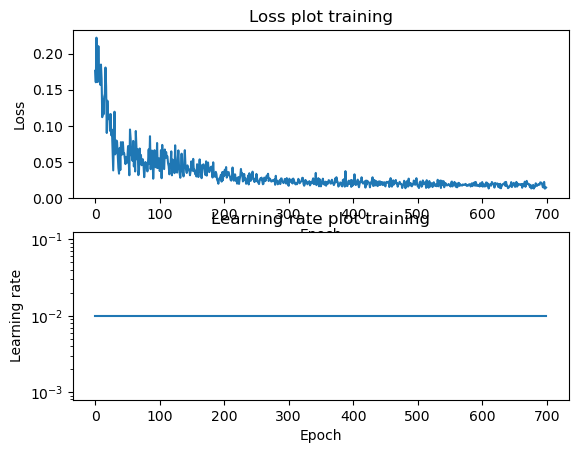

In [6]:
if LOAD_CKPT is None:
    model,out = train(
        model,
        dataset,
        num_iterations=7_000,
        lr=0.01,
        device=DEVICE,
    )
    plt.subplot(2,1,1)
    plt.plot(out['losses'])
    plt.ylim(0)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss plot training")

    plt.subplot(2,1,2)
    plt.plot(out['lr'])
    # plt.ylim(0)
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Learning rate")
    plt.title("Learning rate plot training")

    plt.show()
    fname = "models/model_{}.ckpt".format(datetime.datetime.now().strftime('%a%d%b%H%M').lower())
    torch.save(model.state_dict(),fname)
else:
    model.load_state_dict(torch.load(LOAD_CKPT))

In [7]:
raise NotImplementedError("Not now")
print("Saving results..")
out_dir = os.path.join(os.getcwd(), "renders")

rendering = []
nrow = len(dataset)

cameras = sorted(dataset, key=lambda cam:cam.name)

for camera in cameras:

    camera.to(DEVICE)
    bg = torch.zeros(3,dtype=torch.float, device=DEVICE)

    I = ndarray_to_Image(np.hstack((
        tensor_to_ndarray(camera.gt_image),
        tensor_to_ndarray(model.render(camera, bg=bg))
    )))

    I.save(os.path.join(out_dir,camera.name))
    # rendering.append(I)

# rendering[0].save(
#     os.path.join(out_dir,"rendering.gif"),
#     save_all=True,
#     append_images=rendering[2::2],
#     optimize=False,
#     duration=500,
#     loop=0,
# )

print("Results saved")

NotImplementedError: Not now

In [ ]:
raise NotImplementedError("Not working rn")

from scipy.spatial.transform import Slerp,Rotation
from src.utils.camera import Camera
from scipy.interpolate import LinearNDInterpolator

cameras = sorted(dataset, key=lambda cam:cam.name)[:9:2]

rotmats = Rotation.from_matrix([camera.R for camera in cameras])
slerp = Slerp(range(len(rotmats)),rotmats)

np.interp()

times = np.linspace(0,len(cameras)-1.1,20)

renders = []

for t in T:
    tint = int(t)
    tfrac = t - tint

    c1 = cameras[tint]
    c2 = cameras[tint+1]

    camera = Camera(
        gt_image=None,
        R=slerp(t).as_matrix(),
        t=tfrac * c1.t + (1-tfrac)*c2.t,
        fovx=c1.fovx, fovy=c1.fovy,
        H=c1.H, W=c1.W,
        device=DEVICE
    )

    renders.append(ndarray_to_Image(np.hstack((
        tensor_to_ndarray(c1.gt_image if tfrac<.5 else c2.gt_image),
        tensor_to_ndarray(model.render(camera, bg=bg))
    ))))

renders[0].save(
    os.path.join(out_dir,"rendering_fancy.gif"),
    save_all=True,
    append_images=renders[1:],
    optimize=False,
    duration=500//60,
    loop=0,
)